Using TensorFlow backend.


(50000, 28, 28) (50000,)


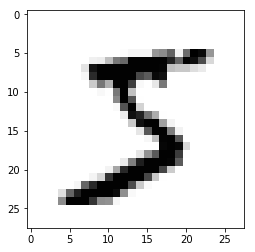

In [1]:
import sys
sys.path += ['week2']

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
from scipy.misc import imrotate, imresize

In [3]:
import tensorflow as tf
import numpy as np

## Preparation

Relaunch tensorboard, and import useful libraries.

In [ ]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

import tensorflow as tf

import numpy as np

# Data inspection and preparation

We first take a look at the data, and prepare a version having just two classes.

In [ ]:
X_train.shape

In [ ]:
y_train[:10]

Let's create a flattened version of the data, because tensorflow has difficulty computing gradients across a reshape node.

In [4]:
rows = 28
cols = 28
classes = 10

s = tf.InteractiveSession()

with tf.variable_scope("1nn-reshaper"):
    # input shape
    x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(y, 10)
    flat_x = tf.reshape(x, [-1, rows * cols])

X_train_flat, y_train_one_hot = s.run([flat_x, one_hot_y], feed_dict={
    x: X_train,
    y: y_train
})

## Single layer neural network

We first create a simple single layer neural network. We use a one_hot encode layer and a reshape layer to create a flat X. This will prove to be troublesome in the future, but it works for the first version. We use a softmax function to compute the predicted classes.

Also, for debugging, we create the `correct_prediction` and `accuracy` nodes, to avoid having to compute these metrics by hand after running the network.

In [5]:
rows = 28
cols = 28
classes = 10

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn"):
    weights = tf.get_variable("weights", 
                              [rows * cols, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=1e-3),
                              dtype=tf.float32)
    b = tf.get_variable("bias", [classes],
                    initializer=tf.random_uniform_initializer(minval=0, maxval=1e-3),
                    dtype=tf.float32)

    input_X = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    input_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(input_y, classes)
    flat_X = tf.reshape(input_X, [-1, rows * cols])
    
    predicted_y = tf.nn.softmax(tf.matmul(flat_X, weights) + b)
    class_loss = -tf.log(predicted_y) * one_hot_y - tf.log(1 - predicted_y) * (1 - one_hot_y)
    loss = tf.reduce_mean(class_loss)
    
    correct_prediction = tf.equal(tf.cast(input_y, tf.int64), tf.argmax(predicted_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Let's test that the weights get correctly initialized.

In [6]:
s.run(tf.global_variables_initializer())
print(s.run([weights, b]))

[array([[ -1.02057366e-03,  -4.27236548e-04,   2.47013268e-05, ...,
         -3.49555718e-04,  -3.32526426e-04,   1.42738491e-03],
       [  4.66067751e-04,  -8.86809372e-04,  -5.22999544e-05, ...,
         -1.69798057e-03,   7.26577418e-05,   2.62943620e-04],
       [ -1.15725701e-03,  -1.74877048e-03,   6.64400926e-04, ...,
          9.60978563e-04,  -1.56462414e-03,  -1.44472253e-03],
       ..., 
       [ -6.23423664e-04,   1.42920669e-03,   7.02040328e-04, ...,
         -1.31052430e-03,   1.44734676e-03,  -8.74818128e-04],
       [ -5.52055193e-04,  -9.15091252e-04,   1.31148787e-04, ...,
          6.25178160e-04,   8.09437421e-04,   1.61222037e-04],
       [  1.86423073e-03,   5.86324604e-04,   1.05774309e-03, ...,
          4.50900057e-04,   1.04007684e-03,   1.71791017e-03]], dtype=float32), array([ 0.00049114,  0.00032053,  0.00095181,  0.00077437,  0.00070904,
        0.00094271,  0.00029195,  0.0003054 ,  0.00092712,  0.00046623], dtype=float32)]


Let's test that the network computes different values correctly, or at least that they seem to be roughly correct. I struggled a bit with different data shapes and wrong initialization. I decided to keep this step to show what pains I went through.

In [7]:
s.run([weights, b, predicted_y, class_loss, one_hot_y, loss, correct_prediction, accuracy],
     {
         input_X: X_train[:3],
         input_y: y_train[:3]
     })

[array([[ -1.02057366e-03,  -4.27236548e-04,   2.47013268e-05, ...,
          -3.49555718e-04,  -3.32526426e-04,   1.42738491e-03],
        [  4.66067751e-04,  -8.86809372e-04,  -5.22999544e-05, ...,
          -1.69798057e-03,   7.26577418e-05,   2.62943620e-04],
        [ -1.15725701e-03,  -1.74877048e-03,   6.64400926e-04, ...,
           9.60978563e-04,  -1.56462414e-03,  -1.44472253e-03],
        ..., 
        [ -6.23423664e-04,   1.42920669e-03,   7.02040328e-04, ...,
          -1.31052430e-03,   1.44734676e-03,  -8.74818128e-04],
        [ -5.52055193e-04,  -9.15091252e-04,   1.31148787e-04, ...,
           6.25178160e-04,   8.09437421e-04,   1.61222037e-04],
        [  1.86423073e-03,   5.86324604e-04,   1.05774309e-03, ...,
           4.50900057e-04,   1.04007684e-03,   1.71791017e-03]], dtype=float32),
 array([ 0.00049114,  0.00032053,  0.00095181,  0.00077437,  0.00070904,
         0.00094271,  0.00029195,  0.0003054 ,  0.00092712,  0.00046623], dtype=float32),
 array([[ 0.10

Finally, compute accuracy metrics when training the network.

In [ ]:
s.run(tf.global_variables_initializer())

losses = []
test_accuracies = []
train_accuracies = []

for i in range(30):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss,  {input_X: X_train, input_y: y_train})
    losses += [loss_i]
    train_accuracies += [s.run(accuracy, {input_X:X_train, input_y: y_train})]
    test_accuracies += [s.run(accuracy, {input_X:X_test, input_y: y_test})]


In [ ]:
plt.figure()
plt.plot(losses);
plt.plot(train_accuracies)
plt.plot(test_accuracies);
plt.legend(['loss', 'training accuracy', 'test accuracy'])


Next, we create a generator that will provide us with randomized minibatches, to do incremental training.

In [131]:
import random

class MiniBatchGenerator:
    def __init__(self, X, y, batch_size):
        self.X = X.copy()
        self.y = y.copy()
        self.batch_size = batch_size
        self.current_i = 0
        self.total_size = len(self.X)
        
        self.reshuffle()
        
    def reshuffle(self):        
        idxs = list(range(self.total_size))
        random.shuffle(idxs)
        self.idxs = np.array(idxs, dtype=np.int32)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        res_idxs = []
        
        end_i = self.current_i + self.batch_size
        
        if end_i > self.total_size:
            rem = end_i - self.total_size
            res_idxs = self.idxs[self.current_i:]
            self.reshuffle()
            res_idxs = np.append(res_idxs, self.idxs[:rem], axis=0)
            self.current_i = rem
        else:
            res_idxs = self.idxs[self.current_i:end_i]
            self.current_i = end_i

        return self.X[res_idxs], self.y[res_idxs]

In [170]:
def train_network(iterations=2000, batch_size=1000, X_train=X_train, y_train=y_train):
    s.run(tf.global_variables_initializer())

    batcher = MiniBatchGenerator(X_train, y_train, batch_size)
    print(X_train.shape)
    print(y_train.shape)

    losses = []
    batch_train_accuracies = []

    val_accuracies = []
    test_accuracies = []

    for i in range(iterations):
        X_batch, y_batch = batcher.next()

        loss_i, accuracy_i, optimizer_i = s.run([
            loss, accuracy, optimizer
        ],  {input_x: X_batch, 
                         label_y: y_batch})

        if i % 100 == 0:        
            losses += [loss_i]
            batch_train_accuracies += [accuracy_i]

            val_accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_val, 
                 label_y: y_val})
            val_accuracies += [val_accuracy_i]

            test_accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_test, 
                 label_y: y_test})
            test_accuracies += [test_accuracy_i]

            print("{} - loss: {}, train: {}, val: {}, test: {}".format(
                i, loss_i, accuracy_i, val_accuracy_i, test_accuracy_i))

    plt.figure()
    plt.plot(losses);
    plt.plot(batch_train_accuracies)
    plt.plot(val_accuracies)
    plt.plot(test_accuracies);
    plt.legend(['loss', 'batch train accuracy', 'validation accuracy', 'test accuracy'])

    l = len(batch_train_accuracies) - 20
    
    plt.figure()
    plt.plot(batch_train_accuracies[-l:])
    plt.plot(test_accuracies[-l:]);
    plt.legend(['batch training accuracy', 'test accuracy'])

## Multilayer neural network

In this neural network, we use a second 50 neuron layer. The first layer has a sigmoid activation function.

In [152]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

import tensorflow as tf

rows = 28
cols = 28
classes = 10

layer_cnt = 0

def add_layer(in_, size, output_f, sigma=1):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    layer_cnt += 1
    return y2

hidden_size = 30

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = 1

    # input layer
    y1 = add_layer(x, 100, tf.nn.sigmoid, sigma=sigma)
    y2 = add_layer(y1, 50, tf.nn.sigmoid, sigma=sigma)
    y3 = add_layer(y2, 50, tf.nn.sigmoid, sigma=sigma)
    y = add_layer(y3, 10, tf.nn.softmax, sigma=sigma)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(2.).minimize(loss)
    
    s.run(tf.global_variables_initializer())



(50000, 28, 28) (50000,)


(50000, 28, 28)
(50000,)
0 - loss: 5.294643402099609, train: 0.10302000492811203, test: 0.10080000013113022
100 - loss: 0.6739616394042969, train: 0.7829201221466064, test: 0.781499981880188
200 - loss: 0.5038734078407288, train: 0.84934002161026, test: 0.847100019454956
300 - loss: 0.3965532183647156, train: 0.8803198933601379, test: 0.8729000687599182
400 - loss: 0.342928409576416, train: 0.8980399370193481, test: 0.8896000981330872
500 - loss: 0.2711547017097473, train: 0.9094399213790894, test: 0.8967001438140869
600 - loss: 0.2824562191963196, train: 0.9176399111747742, test: 0.9035000205039978
700 - loss: 0.2586315870285034, train: 0.9228998422622681, test: 0.9075000882148743
800 - loss: 0.2609403133392334, train: 0.9303198456764221, test: 0.9127001762390137
900 - loss: 0.19397962093353271, train: 0.9353997707366943, test: 0.9150000810623169
1000 - loss: 0.20724773406982422, train: 0.9402598738670349, test: 0.9198000431060791
1100 - loss: 0.20889964699745178, train: 0.94405984878

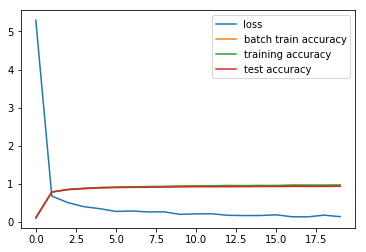

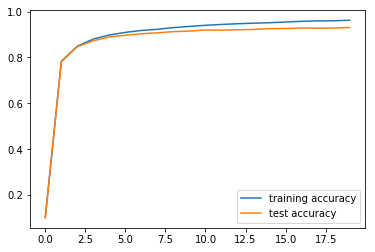

In [11]:
train_network()

In [142]:
expanded_X_train = []
expanded_y_train = []

def img_resize(img, percent):
    img_ = imresize(img, percent)
    offset = int((img_.shape[0] - 28) / 2)
    return img_[offset:offset+28, offset:offset+28]

for i in range(len(X_train)):
    img = X_train[i]
    img_class = y_train[i]

    expanded_X_train += [img]
    expanded_y_train += [img_class]

    for angle in [5, -5, 10, -10, -15, 15, -20, 20]:
#     for angle in [10, -10]:
        img_ = imrotate(img, angle) / 255.
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
    for scale in [120, 110]:
        img_ = img_resize(img, scale) / 255.
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
expanded_X_train = np.array(expanded_X_train)
expanded_y_train = np.array(expanded_y_train)


In [164]:
tf.reset_default_graph()
s = tf.InteractiveSession()

def add_layer_with_loss(in_, size, output_f, sigma=1):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    loss = tf.norm(W2, ord=2)
#     loss = tf.reduce_sum(tf.sqrt(tf.tensordot(tf.squeeze(W2), tf.squeeze(W2), 1)))
#     loss += tf.reduce_sum(tf.sqrt(tf.tensordot(b2, b2, 1)))
    
    layer_cnt += 1
    return y2, loss


with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = .1
    print("sigma", sigma)
  
    # input layer
    loss_lambda = 0.005
    
    y1, loss_ = add_layer_with_loss(x, 100, tf.nn.relu, sigma=sigma)
    loss = loss_lambda * loss_
    y3, loss_ = add_layer_with_loss(y1, 50, tf.nn.relu, sigma=sigma)
    loss += loss_lambda * loss_
    y, loss_ = add_layer_with_loss(y3, 10, tf.nn.softmax, sigma=sigma)
    loss += loss_lambda * loss_

    loss += tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    optimizer = tf.train.GradientDescentOptimizer(.2).minimize(loss)

    
    s.run(tf.global_variables_initializer())

# train_network(iterations=5000, batch_size=1000, X_train=X_train, y_train=y_train)

sigma 0.1


(550000, 28, 28)
(550000,)
0 - loss: 2.506364583969116, train: 0.09490000456571579, test: 0.09969998896121979
100 - loss: 1.0184431076049805, train: 0.8689000606536865, test: 0.8595000505447388
200 - loss: 0.6186179518699646, train: 0.8790001273155212, test: 0.8761000633239746
300 - loss: 0.536602795124054, train: 0.9255000948905945, test: 0.919900119304657
400 - loss: 0.5295209288597107, train: 0.9323000907897949, test: 0.9241001009941101
500 - loss: 0.46293580532073975, train: 0.941300094127655, test: 0.9374001026153564
600 - loss: 0.5049935579299927, train: 0.9427000880241394, test: 0.943100094795227
700 - loss: 0.4693986177444458, train: 0.9469000697135925, test: 0.9422001838684082
800 - loss: 0.4375765323638916, train: 0.9515001177787781, test: 0.9451001286506653
900 - loss: 0.5403689742088318, train: 0.9540001153945923, test: 0.9504001140594482
1000 - loss: 0.32407280802726746, train: 0.9560000896453857, test: 0.953200101852417
1100 - loss: 0.3204535245895386, train: 0.9564000964

9700 - loss: 0.2959875464439392, train: 0.9792001247406006, test: 0.9787001609802246
9800 - loss: 0.2479625642299652, train: 0.9789001941680908, test: 0.9786001443862915
9900 - loss: 0.2487400770187378, train: 0.9789001941680908, test: 0.9799001216888428
10000 - loss: 0.3274245262145996, train: 0.9764001369476318, test: 0.9756002426147461
10100 - loss: 0.33972322940826416, train: 0.9789001941680908, test: 0.9804001450538635
10200 - loss: 0.34316888451576233, train: 0.9772001504898071, test: 0.980100154876709
10300 - loss: 0.31150880455970764, train: 0.9782001972198486, test: 0.9804001450538635
10400 - loss: 0.21852095425128937, train: 0.979400098323822, test: 0.9820001721382141
10500 - loss: 0.23682820796966553, train: 0.9805001020431519, test: 0.9800001382827759
10600 - loss: 0.23280897736549377, train: 0.9805001616477966, test: 0.9800001382827759
10700 - loss: 0.23642948269844055, train: 0.979400098323822, test: 0.980600118637085
10800 - loss: 0.40594226121902466, train: 0.9807001352

19200 - loss: 0.25007712841033936, train: 0.9830000996589661, test: 0.9823001623153687
19300 - loss: 0.1870732456445694, train: 0.9845001697540283, test: 0.981900155544281
19400 - loss: 0.21970190107822418, train: 0.9833001494407654, test: 0.9816001057624817
19500 - loss: 0.1960609406232834, train: 0.9814001321792603, test: 0.9822001457214355
19600 - loss: 0.2668915092945099, train: 0.9824000597000122, test: 0.9826001524925232
19700 - loss: 0.23333939909934998, train: 0.9836001992225647, test: 0.9829001426696777
19800 - loss: 0.19373837113380432, train: 0.9814001321792603, test: 0.9820001125335693
19900 - loss: 0.18446354568004608, train: 0.9788001775741577, test: 0.9808001518249512
20000 - loss: 0.2578282654285431, train: 0.9801000952720642, test: 0.9827001094818115
20100 - loss: 0.1860640048980713, train: 0.9825000762939453, test: 0.9842001795768738
20200 - loss: 0.20390594005584717, train: 0.9814001321792603, test: 0.9838001132011414
20300 - loss: 0.1853538602590561, train: 0.981100

28700 - loss: 0.2643776834011078, train: 0.9839001893997192, test: 0.9835001230239868
28800 - loss: 0.1653590202331543, train: 0.9832001328468323, test: 0.9854000806808472
28900 - loss: 0.16964423656463623, train: 0.9821001291275024, test: 0.9836000800132751
29000 - loss: 0.22020353376865387, train: 0.9832001328468323, test: 0.9844001531600952
29100 - loss: 0.1731974333524704, train: 0.9823002219200134, test: 0.9839001893997192
29200 - loss: 0.1752552092075348, train: 0.9854001402854919, test: 0.9846000671386719
29300 - loss: 0.17781472206115723, train: 0.9825001955032349, test: 0.9822001457214355
29400 - loss: 0.21584337949752808, train: 0.9837000966072083, test: 0.9836001396179199
29500 - loss: 0.24997258186340332, train: 0.9848001003265381, test: 0.9840001463890076
29600 - loss: 0.19280293583869934, train: 0.9825001358985901, test: 0.982900083065033
29700 - loss: 0.1731484830379486, train: 0.9833000898361206, test: 0.9841001033782959
29800 - loss: 0.1812211275100708, train: 0.983100

38200 - loss: 0.1864297091960907, train: 0.9832001328468323, test: 0.9828000664710999
38300 - loss: 0.25457072257995605, train: 0.9767001867294312, test: 0.9741001725196838
38400 - loss: 0.19953900575637817, train: 0.983500063419342, test: 0.9840000867843628
38500 - loss: 0.2002888023853302, train: 0.9824000597000122, test: 0.9845000505447388
38600 - loss: 0.1653943657875061, train: 0.9817001819610596, test: 0.9823001027107239
38700 - loss: 0.16879168152809143, train: 0.9836001396179199, test: 0.9851001501083374
38800 - loss: 0.17820538580417633, train: 0.9827001094818115, test: 0.9846001267433167
38900 - loss: 0.20431286096572876, train: 0.984700083732605, test: 0.9859001636505127
39000 - loss: 0.16882842779159546, train: 0.9808000326156616, test: 0.9811001420021057
39100 - loss: 0.1550610065460205, train: 0.9844000339508057, test: 0.9848001599311829
39200 - loss: 0.16128340363502502, train: 0.9832001328468323, test: 0.9827001094818115
39300 - loss: 0.22731098532676697, train: 0.98350

47700 - loss: 0.19720539450645447, train: 0.9814001321792603, test: 0.9816001653671265
47800 - loss: 0.23384346067905426, train: 0.983500063419342, test: 0.9851000905036926
47900 - loss: 0.15788955986499786, train: 0.9841001033782959, test: 0.9842001795768738
48000 - loss: 0.24067138135433197, train: 0.9821001291275024, test: 0.9833001494407654
48100 - loss: 0.23903821408748627, train: 0.9817001223564148, test: 0.983100175857544
48200 - loss: 0.1584601253271103, train: 0.9840001463890076, test: 0.9857001900672913
48300 - loss: 0.17608797550201416, train: 0.9827001690864563, test: 0.9850000739097595
48400 - loss: 0.18075741827487946, train: 0.982400119304657, test: 0.984200119972229
48500 - loss: 0.15911483764648438, train: 0.9836000800132751, test: 0.9853001236915588
48600 - loss: 0.17482741177082062, train: 0.9836001396179199, test: 0.9838000535964966
48700 - loss: 0.1763899028301239, train: 0.9839000701904297, test: 0.9848001003265381
48800 - loss: 0.16668584942817688, train: 0.98240

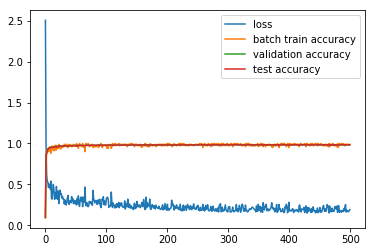

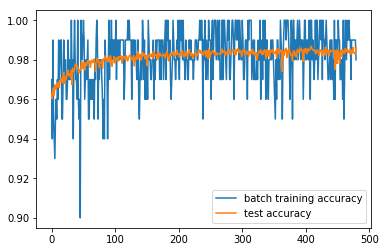

In [166]:
train_network(iterations=50000, batch_size=100, X_train=expanded_X_train, y_train=expanded_y_train)

sigma 0.1
(550000, 28, 28)
(550000,)
0 - loss: 2.516963243484497, train: 0.06999999284744263, val: 0.13239999115467072, test: 0.14159999787807465
100 - loss: 0.6381112337112427, train: 0.85999995470047, val: 0.8750001192092896, test: 0.8692000508308411
200 - loss: 0.5493131875991821, train: 0.8899999856948853, val: 0.8970000743865967, test: 0.8949000835418701
300 - loss: 0.7462133169174194, train: 0.8500000238418579, val: 0.9074000120162964, test: 0.9020000696182251
400 - loss: 0.5483883023262024, train: 0.8600000739097595, val: 0.9134001135826111, test: 0.9068000912666321
500 - loss: 0.6622713804244995, train: 0.8399999141693115, val: 0.9175000786781311, test: 0.9142001271247864
600 - loss: 0.43856173753738403, train: 0.89000004529953, val: 0.9291001558303833, test: 0.9278000593185425
700 - loss: 0.37174612283706665, train: 0.9200000166893005, val: 0.9307000637054443, test: 0.9282001256942749
800 - loss: 0.5268652439117432, train: 0.8600000143051147, val: 0.9344001412391663, test: 0.9

7500 - loss: 0.2182808816432953, train: 0.9699999690055847, val: 0.9729000926017761, test: 0.9734001755714417
7600 - loss: 0.3081393837928772, train: 0.9300000071525574, val: 0.9714001417160034, test: 0.9730000495910645
7700 - loss: 0.24038773775100708, train: 0.9600000381469727, val: 0.9734001159667969, test: 0.9735001921653748
7800 - loss: 0.2097892314195633, train: 0.9799999594688416, val: 0.9729001522064209, test: 0.9739001989364624
7900 - loss: 0.3084479570388794, train: 0.9399999976158142, val: 0.9731001257896423, test: 0.973000168800354
8000 - loss: 0.24866530299186707, train: 0.9799999594688416, val: 0.973000168800354, test: 0.9751001596450806
8100 - loss: 0.27249377965927124, train: 0.9399999976158142, val: 0.9721001386642456, test: 0.9739001989364624
8200 - loss: 0.2822045087814331, train: 0.949999988079071, val: 0.9722001552581787, test: 0.9736001491546631
8300 - loss: 0.22648049890995026, train: 0.9799999594688416, val: 0.9721001386642456, test: 0.974600076675415
8400 - los

15000 - loss: 0.1861594319343567, train: 0.9800000190734863, val: 0.9760001301765442, test: 0.9765000939369202
15100 - loss: 0.2587902843952179, train: 0.9700000286102295, val: 0.9748002290725708, test: 0.9743001461029053
15200 - loss: 0.2589018940925598, train: 0.9599999785423279, val: 0.9731001853942871, test: 0.9723001718521118
15300 - loss: 0.22050243616104126, train: 0.9700000286102295, val: 0.9736000895500183, test: 0.9726001620292664
15400 - loss: 0.2641478180885315, train: 0.9399999976158142, val: 0.9768002033233643, test: 0.9752000570297241
15500 - loss: 0.23764446377754211, train: 0.9600000381469727, val: 0.9755001068115234, test: 0.9757001399993896
15600 - loss: 0.2801802158355713, train: 0.9399999976158142, val: 0.976600170135498, test: 0.9761000275611877
15700 - loss: 0.2512117028236389, train: 0.9699999690055847, val: 0.9753000736236572, test: 0.9751001596450806
15800 - loss: 0.19809271395206451, train: 0.9699999690055847, val: 0.9756000638008118, test: 0.9747001528739929

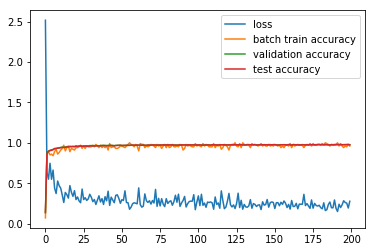

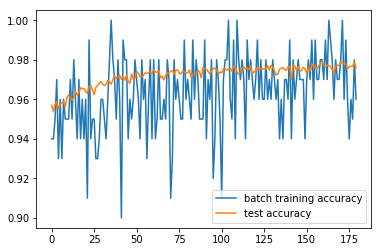

In [171]:
with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = .1
    print("sigma", sigma)
  
    # input layer
    loss_lambda = 0.005
    
    y1, loss_ = add_layer_with_loss(x, 50, tf.nn.relu, sigma=sigma)
    loss = loss_lambda * loss_
    y, loss_ = add_layer_with_loss(y1, 10, tf.nn.softmax, sigma=sigma)
    loss += loss_lambda * loss_

    loss += tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    optimizer = tf.train.GradientDescentOptimizer(.2).minimize(loss)

    
    s.run(tf.global_variables_initializer())

train_network(iterations=20000, batch_size=100, X_train=expanded_X_train, y_train=expanded_y_train)

sigma 0.1
(550000, 28, 28)
(550000,)
0 - loss: 2.5202882289886475, train: 0.12999999523162842, val: 0.09629999846220016, test: 0.10180000215768814
100 - loss: 1.6236255168914795, train: 0.6599999666213989, val: 0.7706000804901123, test: 0.7666000127792358
200 - loss: 1.2135347127914429, train: 0.75, val: 0.8440000414848328, test: 0.8411000370979309
300 - loss: 0.8754950761795044, train: 0.8399999737739563, val: 0.8613000512123108, test: 0.8577000498771667
400 - loss: 0.7491481304168701, train: 0.8600000143051147, val: 0.8785000443458557, test: 0.8751000761985779
500 - loss: 0.8769623637199402, train: 0.8299999237060547, val: 0.8897000551223755, test: 0.8831000924110413
600 - loss: 0.8083888292312622, train: 0.7899999618530273, val: 0.8927000761032104, test: 0.887100100517273
700 - loss: 0.8379278779029846, train: 0.809999942779541, val: 0.895500123500824, test: 0.8928001523017883
800 - loss: 0.7666182518005371, train: 0.8599998950958252, val: 0.9011001586914062, test: 0.895900070667266

7500 - loss: 0.43826523423194885, train: 0.9300000071525574, val: 0.9544000625610352, test: 0.9511001110076904
7600 - loss: 0.45394301414489746, train: 0.949999988079071, val: 0.9536001086235046, test: 0.9517000913619995
7700 - loss: 0.5231266021728516, train: 0.9100000262260437, val: 0.9544001221656799, test: 0.9516001343727112
7800 - loss: 0.4307243824005127, train: 0.949999988079071, val: 0.9528001546859741, test: 0.9532001614570618
7900 - loss: 0.49483010172843933, train: 0.9599999785423279, val: 0.9550001621246338, test: 0.9526001214981079
8000 - loss: 0.445387601852417, train: 0.9399999976158142, val: 0.9552001953125, test: 0.9527001976966858
8100 - loss: 0.5017479658126831, train: 0.9300000071525574, val: 0.9542001485824585, test: 0.9528001546859741
8200 - loss: 0.49220216274261475, train: 0.9099999666213989, val: 0.9549001455307007, test: 0.9524002075195312
8300 - loss: 0.38445141911506653, train: 0.9600000381469727, val: 0.9542001485824585, test: 0.9516001343727112
8400 - loss

15000 - loss: 0.36226022243499756, train: 0.9699999690055847, val: 0.9641001224517822, test: 0.9632001519203186
15100 - loss: 0.45247575640678406, train: 0.940000057220459, val: 0.9636001586914062, test: 0.9632002115249634
15200 - loss: 0.37060973048210144, train: 0.9799999594688416, val: 0.9628000855445862, test: 0.9631000757217407
15300 - loss: 0.30719107389450073, train: 0.9800000190734863, val: 0.964600145816803, test: 0.9632000923156738
15400 - loss: 0.38052859902381897, train: 0.949999988079071, val: 0.9634001851081848, test: 0.9630001187324524
15500 - loss: 0.5997624397277832, train: 0.9200000166893005, val: 0.9635001420974731, test: 0.963900089263916
15600 - loss: 0.33444103598594666, train: 0.9799999594688416, val: 0.9641002416610718, test: 0.9644001126289368
15700 - loss: 0.3904646337032318, train: 0.9599999189376831, val: 0.9648001194000244, test: 0.9653001427650452
15800 - loss: 0.6184228658676147, train: 0.8700000047683716, val: 0.9639002084732056, test: 0.96340012550354
1

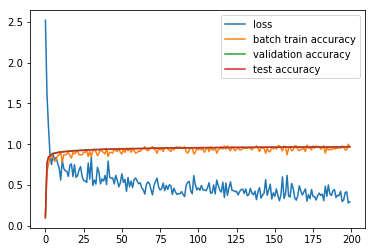

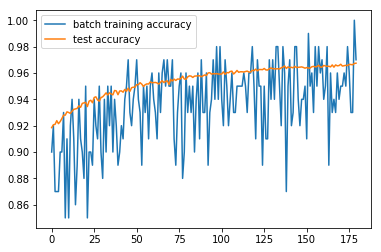

In [172]:
with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = .1
    print("sigma", sigma)
  
    # input layer
    loss_lambda = 0.005
    
    y1, loss_ = add_layer_with_loss(x, 50, tf.nn.relu, sigma=sigma)
    loss = loss_lambda * loss_
    y1, loss_ = add_layer_with_loss(x, 50, tf.nn.sigmoid, sigma=sigma)
    loss += loss_lambda * loss_
    y, loss_ = add_layer_with_loss(y1, 10, tf.nn.softmax, sigma=sigma)
    loss += loss_lambda * loss_

    loss += tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    optimizer = tf.train.GradientDescentOptimizer(.2).minimize(loss)

    
    s.run(tf.global_variables_initializer())

train_network(iterations=20000, batch_size=100, X_train=expanded_X_train, y_train=expanded_y_train)

sigma 0.1
(550000, 28, 28)
(550000,)
0 - loss: 2.559730052947998, train: 0.10999999940395355, val: 0.1647000014781952, test: 0.1622999906539917
100 - loss: 0.7702843546867371, train: 0.8200000524520874, val: 0.8691999912261963, test: 0.8670000433921814
200 - loss: 0.7857537269592285, train: 0.8700000047683716, val: 0.8893001079559326, test: 0.8832001090049744
300 - loss: 0.6717348098754883, train: 0.8700000047683716, val: 0.9144001007080078, test: 0.9123001098632812
400 - loss: 0.5826727747917175, train: 0.8899999856948853, val: 0.9188000559806824, test: 0.9168000817298889
500 - loss: 0.6754369735717773, train: 0.8499999642372131, val: 0.9238001704216003, test: 0.9152001142501831
600 - loss: 0.548420786857605, train: 0.8899999856948853, val: 0.930600106716156, test: 0.9299001693725586
700 - loss: 0.5353260040283203, train: 0.8899999856948853, val: 0.9322001338005066, test: 0.9284000396728516
800 - loss: 0.6349619626998901, train: 0.9000000357627869, val: 0.9369001388549805, test: 0.932

7500 - loss: 0.28131020069122314, train: 0.9799999594688416, val: 0.9721001386642456, test: 0.972300112247467
7600 - loss: 0.33032411336898804, train: 0.9699999690055847, val: 0.9727001190185547, test: 0.9721001386642456
7700 - loss: 0.29617685079574585, train: 0.9700000286102295, val: 0.9711000919342041, test: 0.9737001657485962
7800 - loss: 0.27608737349510193, train: 0.9800000190734863, val: 0.973000168800354, test: 0.9718001484870911
7900 - loss: 0.2420508861541748, train: 1.0, val: 0.9724001884460449, test: 0.9711001515388489
8000 - loss: 0.29662570357322693, train: 0.9799999594688416, val: 0.9723000526428223, test: 0.9719001054763794
8100 - loss: 0.27910351753234863, train: 0.9700000286102295, val: 0.9744001030921936, test: 0.9722001552581787
8200 - loss: 0.3619883358478546, train: 0.949999988079071, val: 0.9730001091957092, test: 0.9716001749038696
8300 - loss: 0.2873200476169586, train: 0.9799999594688416, val: 0.9737001061439514, test: 0.9747001528739929
8400 - loss: 0.3322720

15000 - loss: 0.3255302309989929, train: 0.9600000381469727, val: 0.9770001769065857, test: 0.9765001535415649
15100 - loss: 0.21763017773628235, train: 0.9799999594688416, val: 0.9759001731872559, test: 0.977100133895874
15200 - loss: 0.37664705514907837, train: 0.9099999666213989, val: 0.9756001234054565, test: 0.9756001234054565
15300 - loss: 0.26693782210350037, train: 0.9600000381469727, val: 0.9758001565933228, test: 0.9763001799583435
15400 - loss: 0.24971610307693481, train: 0.9699999690055847, val: 0.9764001369476318, test: 0.977100133895874
15500 - loss: 0.26297199726104736, train: 0.9599999785423279, val: 0.9758001565933228, test: 0.9764001369476318
15600 - loss: 0.18109358847141266, train: 1.0, val: 0.97760009765625, test: 0.9770001173019409
15700 - loss: 0.21472477912902832, train: 0.9899999499320984, val: 0.9754000902175903, test: 0.9773001074790955
15800 - loss: 0.3553708791732788, train: 0.9399999380111694, val: 0.9772001504898071, test: 0.9750002026557922
15900 - loss:

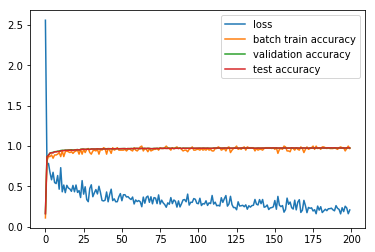

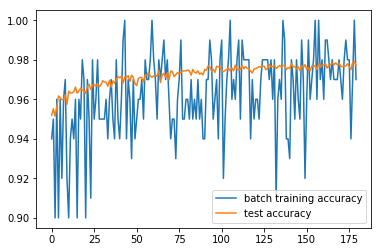

In [173]:
with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = .1
    print("sigma", sigma)
  
    # input layer
    loss_lambda = 0.005
    
    y1, loss_ = add_layer_with_loss(x, 50, tf.nn.relu, sigma=sigma)
    loss = loss_lambda * loss_
    y1, loss_ = add_layer_with_loss(x, 50, tf.nn.relu, sigma=sigma)
    loss += loss_lambda * loss_
    y, loss_ = add_layer_with_loss(y1, 10, tf.nn.softmax, sigma=sigma)
    loss += loss_lambda * loss_

    loss += tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    optimizer = tf.train.GradientDescentOptimizer(.2).minimize(loss)

    
    s.run(tf.global_variables_initializer())

train_network(iterations=20000, batch_size=100, X_train=expanded_X_train, y_train=expanded_y_train)

In [98]:

%load_ext line_profiler

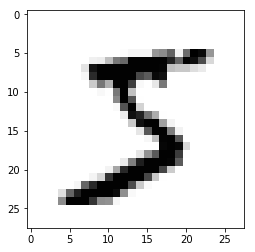

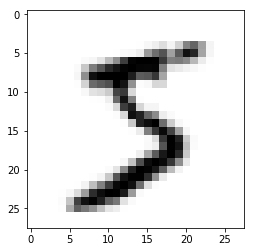

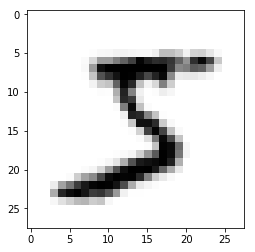

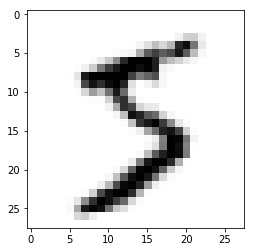

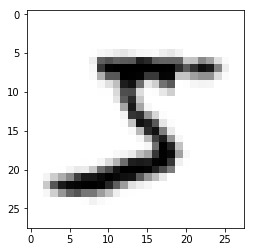

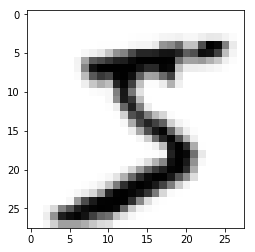

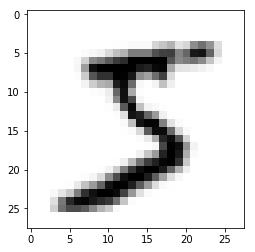

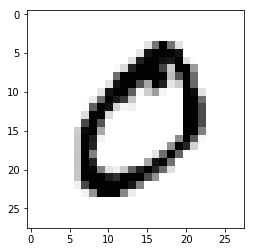

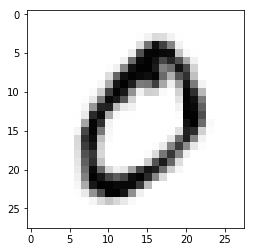

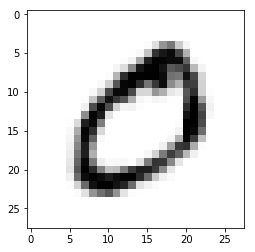

In [95]:
for i in range(10):
    plt.figure()
    plt.imshow(expanded_X_train[i], cmap="Greys");